<a href="https://colab.research.google.com/github/alahkdmovak/Pronostico_aguacates/blob/main/Precio_aguacates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
##**Predicción del precio del Aguacate**

Tratamiento de Señales III

**Facultad de Ingeniería**

**Universidad de Antioquia**

**Estudiantes:** Alahkdmovak Rúa Cardona - Harrison Andres Henao

In [209]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import seaborn as sns

## **Base de datos**

In [210]:
!wget "https://raw.githubusercontent.com/alahkdmovak/Pronostico_aguacates/main/avocado.csv" -O "avocado.csv"

--2023-06-08 08:18:04--  https://raw.githubusercontent.com/alahkdmovak/Pronostico_aguacates/main/avocado.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1989197 (1.9M) [text/plain]
Saving to: ‘avocado.csv’

avocado.csv         100%[===================>]   1.90M  --.-KB/s    in 0.01s   

2023-06-08 08:18:04 (164 MB/s) - ‘avocado.csv’ saved [1989197/1989197]



**La base de datos se obtuvo de https://hassavocadoboard.com/, y en esta se encuentran el promedio de precios del aguacate que fueron tomados semanalmente durante algo mas de 3 años en distintas tiendas o mercados en el pais de Estados Unidos. Tambien hay otras variables pero en este cso nos centraremos en las fechas y los precios del aguacate**

In [211]:
df = pd.read_csv('avocado.csv')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


Se verifica el tipo de dato con el que se va a trabajar.

In [212]:
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

In [213]:
# Conversión de la columna de fechas a formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.rename(columns={'Date':'ds', 'AveragePrice':'y'}, inplace=True)

Se verifica que no hayan datos nulos que puedan afectar el posterior tratamiento de la señal

In [214]:
df[df.isnull()].count()

Unnamed: 0      0
ds              0
y               0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [215]:
# Vemos a ver si hay fechas duplicadas. En tal caso tendríamos que agruparlas y agregar adecuadamente el resto de columnas
df[df.ds.duplicated()]['ds'].count()

18080

In [216]:
grouped_df = df.groupby('ds').size().reset_index(name='count')
for _, row in grouped_df.iterrows():
    print(row['ds'], row['count'])

2015-01-04 00:00:00 108
2015-01-11 00:00:00 108
2015-01-18 00:00:00 108
2015-01-25 00:00:00 108
2015-02-01 00:00:00 108
2015-02-08 00:00:00 108
2015-02-15 00:00:00 108
2015-02-22 00:00:00 108
2015-03-01 00:00:00 108
2015-03-08 00:00:00 108
2015-03-15 00:00:00 108
2015-03-22 00:00:00 108
2015-03-29 00:00:00 108
2015-04-05 00:00:00 108
2015-04-12 00:00:00 108
2015-04-19 00:00:00 108
2015-04-26 00:00:00 108
2015-05-03 00:00:00 108
2015-05-10 00:00:00 108
2015-05-17 00:00:00 108
2015-05-24 00:00:00 108
2015-05-31 00:00:00 108
2015-06-07 00:00:00 108
2015-06-14 00:00:00 108
2015-06-21 00:00:00 108
2015-06-28 00:00:00 108
2015-07-05 00:00:00 108
2015-07-12 00:00:00 108
2015-07-19 00:00:00 108
2015-07-26 00:00:00 108
2015-08-02 00:00:00 108
2015-08-09 00:00:00 108
2015-08-16 00:00:00 108
2015-08-23 00:00:00 108
2015-08-30 00:00:00 108
2015-09-06 00:00:00 108
2015-09-13 00:00:00 108
2015-09-20 00:00:00 108
2015-09-27 00:00:00 108
2015-10-04 00:00:00 108
2015-10-11 00:00:00 108
2015-10-18 00:00

In [217]:
print('Fecha inicio del histórico: ', df.ds.min())
print('Fecha fin del histórico: ', df.ds.max())
print('Número total de semanas: ', df.ds.nunique())

Fecha inicio del histórico:  2015-01-04 00:00:00
Fecha fin del histórico:  2018-03-25 00:00:00
Número total de semanas:  169


<ipython-input-218-da31e517c894>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  por_años = por_años.groupby(['year', 'month']).sum().reset_index()


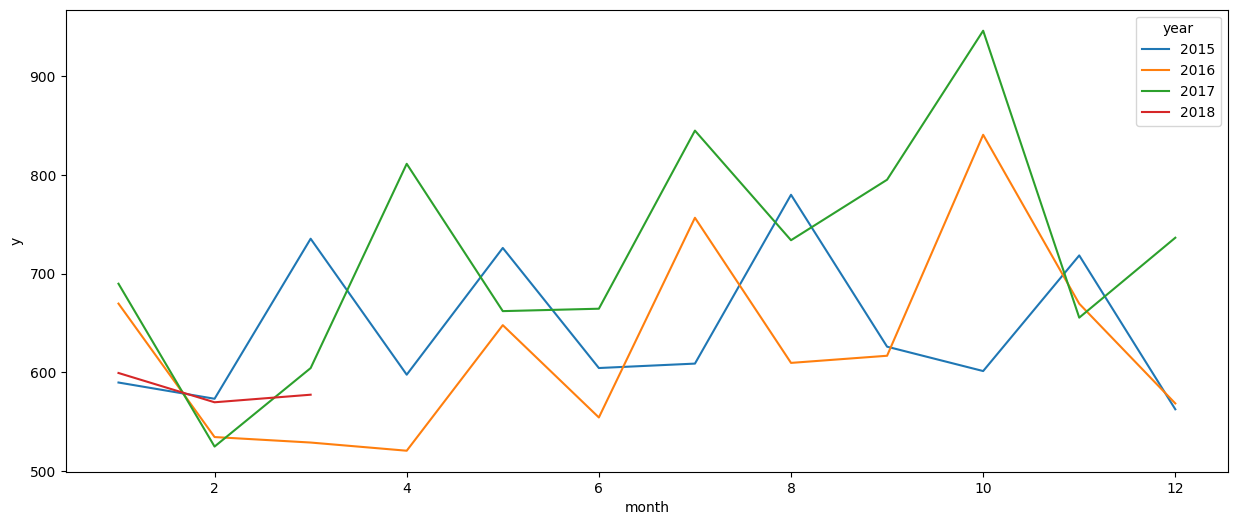

In [218]:
por_años = df[['ds', 'y']].copy()
por_años['year'] = por_años.ds.dt.year
por_años['month'] = por_años.ds.dt.month
por_años = por_años.groupby(['year', 'month']).sum().reset_index()

plt.close()
palette = sns.color_palette("mako_r", 4)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=por_años, x='month', y='y', hue='year', ax=ax, palette= 'tab10')
plt.show()

<ipython-input-219-1bbcddfc3eca>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  por_meses = por_meses.groupby(['month', 'week']).sum().reset_index()


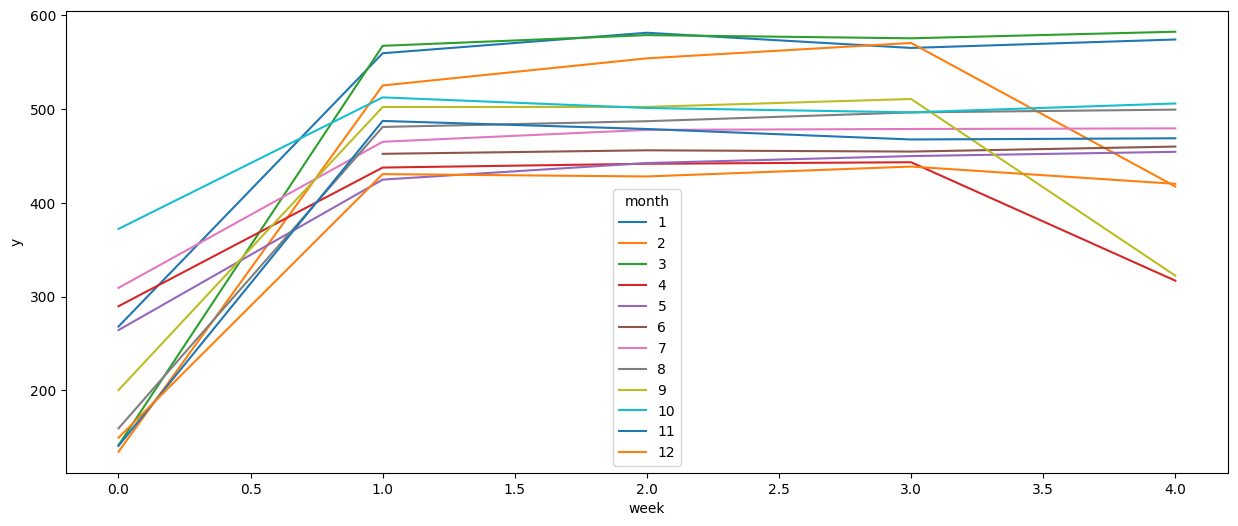

In [219]:
from math import ceil

# Función que devuelve la semana dentro del mes (de 1 a 4)
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom - first_day.weekday()
    return int(ceil(adjusted_dom/7.0))


por_meses = df[['ds', 'y']].copy()
por_meses['week'] = por_meses.ds.apply(week_of_month)
por_meses['month'] = por_meses.ds.dt.month
por_meses = por_meses.groupby(['month', 'week']).sum().reset_index()

plt.close()
palette = sns.color_palette("mako_r", 12)
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(data = por_meses,x = por_meses['week'],y= por_meses['y'], hue=por_meses['month'], ax=ax, palette= 'tab10')
plt.show()

<ipython-input-220-3b3e38a8fb74>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W', on='ds').mean()


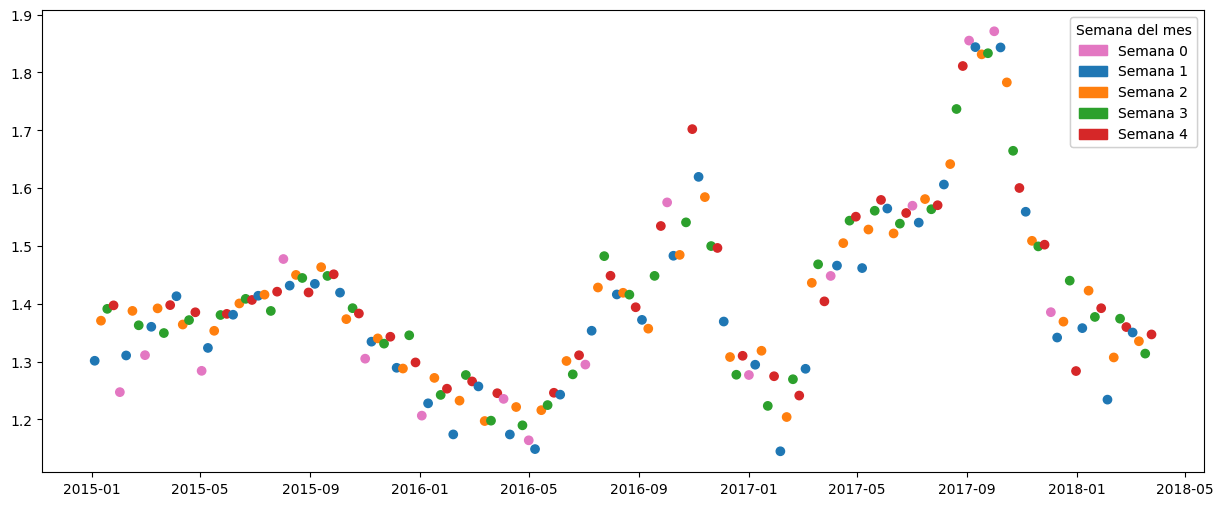

In [220]:
week_colors = { 0: 'tab:pink',1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green', 4: 'tab:red'}

df_weekly = df.resample('W', on='ds').mean()
df_weekly.reset_index(inplace=True)

plt.close()
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(df_weekly['ds'], df_weekly['y'], c=df_weekly.ds.apply(week_of_month).map(week_colors))
handles = [mpatches.Patch(color=v, label=f'Semana {k}') for k, v in week_colors.items()]
legend = ax.legend(handles=handles, bbox_to_anchor=(1, 1), title="Semana del mes")
ax.add_artist(legend)
plt.show()


In [240]:
# Estacionalidades
df_weekly['semanas_2015'] = [True if (dt.week <= 72) else False for dt in df_weekly['ds']]
                         
df_weekly['semanas_2016_o_mas'] = [False if (dt.week <= 72) else True for dt in df_weekly['ds']]

estacionalidades = ['semanas_2015', 'semanas_2016_o_mas']

In [261]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from pandas import Timestamp
params = {'growth': 'linear',
          'changepoints':['2016-05-15'],
          'yearly_seasonality': False,
          'weekly_seasonality': False,
          'daily_seasonality': False,
          'seasonality_mode': 'multiplicative'}

seasonalities = [{'name': 'yearly', 'period': 52, 'fourier_order':25},
                 {'name': 'weekly_antes_mayo_2016', 'period': 1, 'prior_scale':2, 
                  'fourier_order':2, 'condition_name': 'semanas_2015'},
                 {'name': 'weekly_despues_mayo_2016', 'period': 1, 'prior_scale':1,
                  'fourier_order':4, 'condition_name': 'semanas_2016_o_mas'},
                 {'name': 'monthly', 'period': 4, 'fourier_order':9}]


m = Prophet(**params)
for s in seasonalities:
    m.add_seasonality(**s)

# Definir el índice de corte para la partición
indice_corte = int(len(df) * 0.8)

# Particionar el DataFrame
df_train = df.iloc[:indice_corte]
df_test = df.iloc[indice_corte:]

m.fit(df_train)
forecast_test = m.predict(df_test)
forecast_train = m.predict(df_train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwahijoi2/4wju0hpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwahijoi2/v54dgrz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49936', 'data', 'file=/tmp/tmpwahijoi2/4wju0hpk.json', 'init=/tmp/tmpwahijoi2/v54dgrz5.json', 'output', 'file=/tmp/tmpwahijoi2/prophet_modelq1lvgud3/prophet_model-20230608084318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


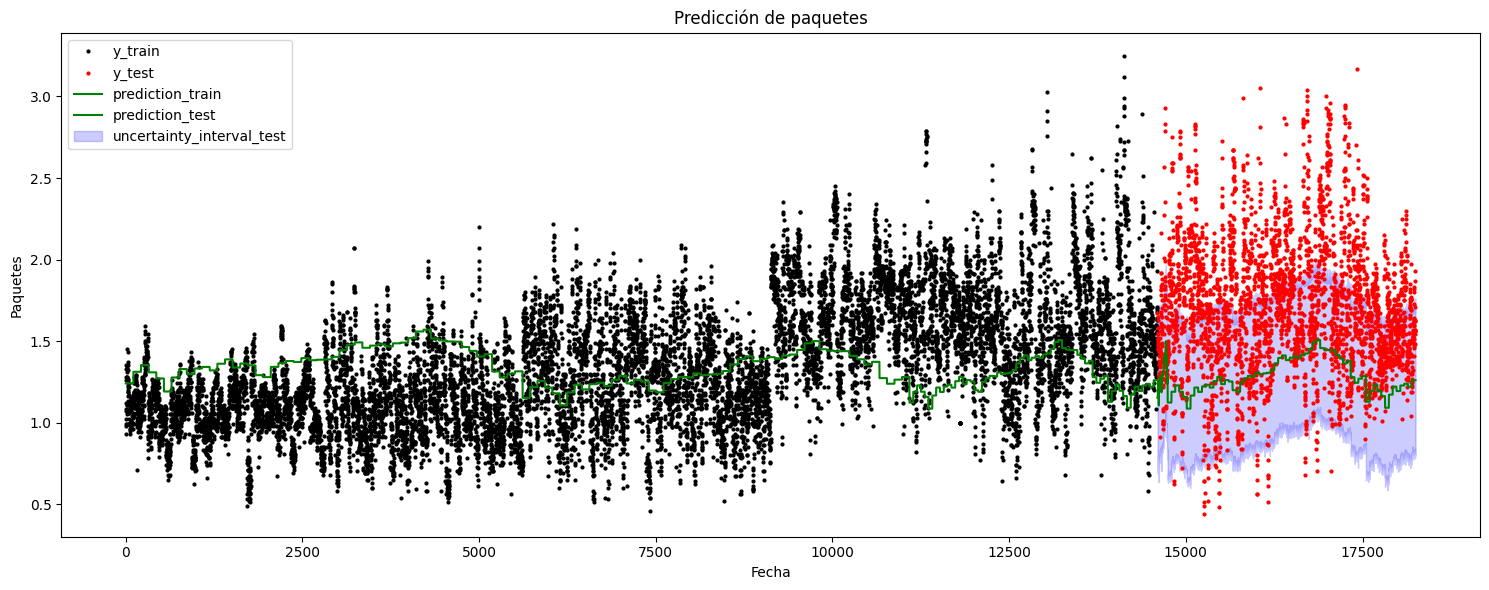

In [262]:
# Gráfica de la predicción

t = np.linspace(0,len(df)+1, len(df))
t1 = t[0:indice_corte]
t2 = t[indice_corte:]
plt.close()
legend = ['y_train', 'y_test', 'prediction_train', 'prediction_test']

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_train['y'], c='black', marker='o', markersize=2, ls='')
ax.plot(df_test['y'], c='r', marker='o', markersize=2, ls='')
ax.plot(forecast_train['yhat'], ls='-', color='green', alpha=1)
ax.plot(t2, forecast_test['yhat'], ls='-', color='green', alpha=1)
ax.fill_between(t2, forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='b', alpha=0.2)
legend.append('uncertainty_interval_test')
ax.legend(legend)
ax.set(title='Predicción de paquetes', xlabel='Fecha', ylabel='Paquetes')
plt.tight_layout()
plt.show()

In [ ]:
# Gráfica de la predicción

t = np.linspace(0,len(df_weekly)+1, len(df_weekly))
t1 = t[0:indice_corte]
t2 = t[indice_corte:]
plt.close()
legend = ['y_train', 'y_test', 'prediction_train', 'prediction_test']

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_train['ds'], df_train['y'], c='black', marker='o', markersize=2, ls='')
ax.plot(df_test['ds'], df_test['y'], c='r', marker='o', markersize=2, ls='')
ax.plot(forecast_train['ds'],forecast_train['yhat'], ls='-', color='green', alpha=1)
ax.plot(forecast_test['ds'], forecast_test['yhat'], ls='-', color='green', alpha=1)
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='b', alpha=0.2)
legend.append('uncertainty_interval_test')
ax.legend(legend, bbox_to_anchor=(1.0, 1.05))
ax.set(title='Predicción de paquetes', xlabel='Fecha', ylabel='Paquetes')
plt.tight_layout()
plt.show()

In [224]:
from sklearn.metrics import r2_score

def MAPE(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean([100*abs((actual[i]-forecast[i])/actual[i]) for i in range(len(actual))])

def metrics(df_train, forecast_train, df_test, forecast_test):
    MAPE_metric = pd.DataFrame(index=['MAPE'],
                               data={'Train': [MAPE(df_train['y'], forecast_train['yhat'])],
                                    'Test': [MAPE(df_test['y'], forecast_test['yhat'])]})
    r2_metric = pd.DataFrame(index=['R2'],
                             data={'Train': [100*r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])],
                                   'Test': [100*r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])]})

    return pd.concat([MAPE_metric, r2_metric])

In [225]:
df_2 = df.drop(['ds','type','region'], axis=1)
print(df_2['y'])

0        1.33
1        1.35
2        0.93
3        1.08
4        1.28
         ... 
18244    1.63
18245    1.71
18246    1.87
18247    1.93
18248    1.62
Name: y, Length: 18249, dtype: float64


Número de muestras: 18249
Número de características: 13


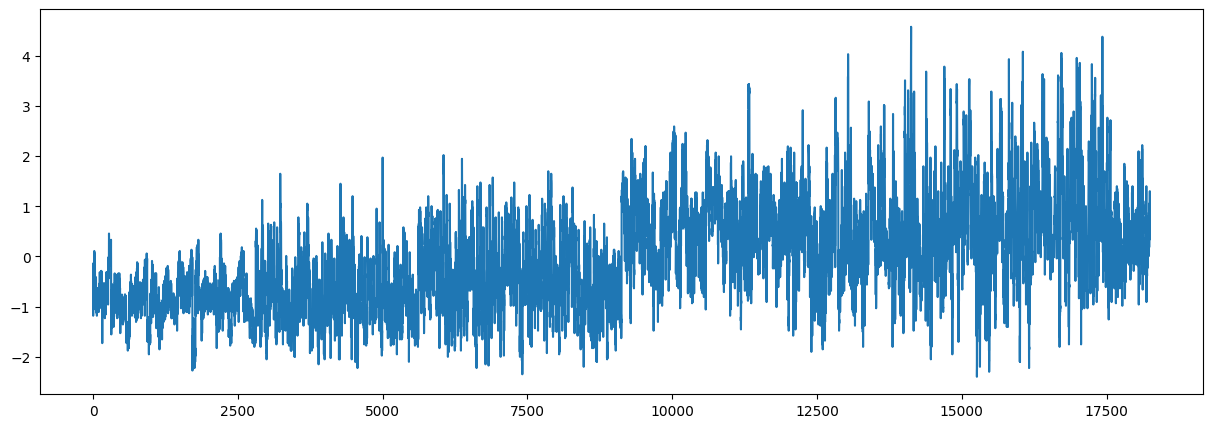

In [226]:
# Convertir la etiqueta en un array de enteros (opcional)
scaler = StandardScaler()
scaler.fit(df_2)
X= scaler.transform(df_2)
# Imprimir el número de ejemplos y características
print('Número de muestras:', X.shape[0])
print('Número de características:', X.shape[1])

plt.figure(figsize=(15,5))
plt.plot(X[:,1])
#plt.xlim(0,10000)

In [227]:
! pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [228]:
from sktime.forecasting.fbprophet import Prophet

##**Regresión lineal con funciones base**

In [229]:
def trigo_carac(X, K): # FUNCIÓN BASE TRIGONOMETRICA(SENO Y COSENO)
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.00002
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi

##**Inferencia mediante maxima verosimilitud**

In [230]:
def inferencia_max_vero_carac_ridge(Phi, y, alpha):
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + alpha * np.eye(D) # Phi^T*Phi + alpha*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi + alpha*I)*Phi^T*y 
    return theta_ml

In [231]:
#FUNCIÓN PARA LA INFERENCIA CON MAXIMA VEROSIMILITUD

def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados 
    
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y 
    return theta_ml

In [232]:
datos2 = X[:,1]
porcion = int(len(datos2)*0.8)
muestras = np.linspace(0,len(datos2)+1,len(datos2))
Xtrain_sec = muestras[0:porcion] # 70% entrenamiento
ytrain_sec = datos2[0:porcion]

Xtest_sec = muestras[porcion:] # 30% test
ytest_sec = datos2[porcion:]

In [233]:
def plot_prediccion(X, prediccion):

  plt.plot(Xtrain_sec, ytrain_sec, '.k')
  plt.plot(X, datos2, lw=2)
  plt.plot(X, prediccion, '--', lw=2)
  plt.xlabel("Time[s]")
  plt.ylabel("Vx[m/s]")
  plt.legend(['datos entrenamiento', 'función real', 'predicción'])

In [234]:
#////////////Trigonometrica///////////
K = 12000 # Numero de funciones base

alpha = 1e-5 # Valor de regularización (ajusta según sea necesario)


Phi2_sec = trigo_carac(Xtrain_sec, K) # transformación de datos con función trigonometrica
#theta_ml2_sec = inferencia_max_vero_carac(Phi2_sec, ytrain_sec)
theta_ml2_sec = inferencia_max_vero_carac_ridge(Phi2_sec, ytrain_sec, alpha)

Phi_test2_sec = trigo_carac(muestras, K) # características todos los datos
y_pred2_sec = Phi_test2_sec @ theta_ml2_sec # predicción

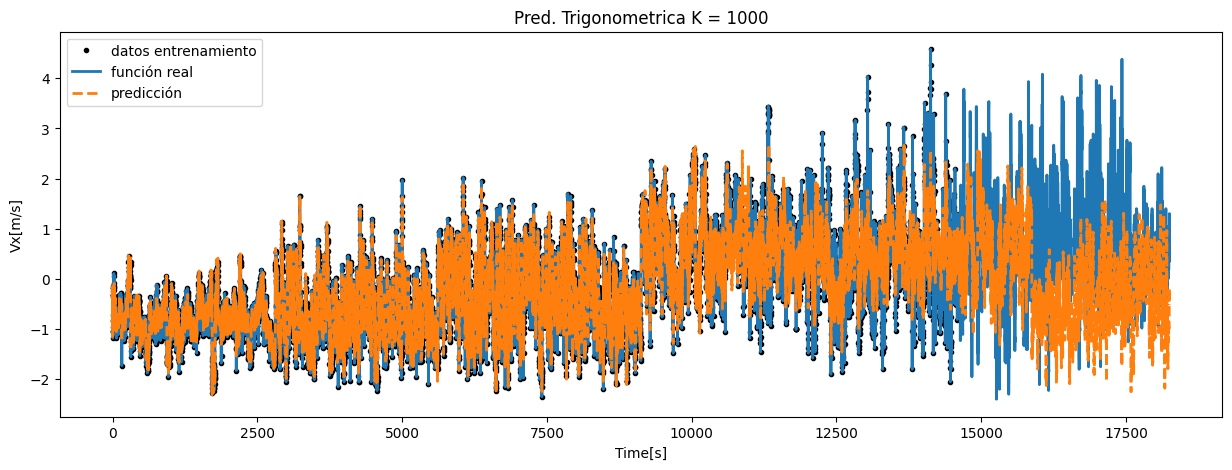

In [235]:
# graficar resultados
plt.figure(figsize=(15,5))
plot_prediccion(muestras, y_pred2_sec)
#plt.xlim(14000,16000)
plt.title('Pred. Trigonometrica K = 1000');
